In [1]:
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

In [2]:
def rgb2gray(rgb):
    # Sets each pixel to a weighted value
    grayed = 0.2126 * rgb[:,:,0] + 0.7152 * rgb[:,:,1] + 0.0722 * rgb[:,:,2]
    return grayed

In [3]:
# Mask is a zero matrix
# fillMask fills an empty numpy array with 255 for pixels that fits inside the defined triangle
def fillMask(mask):
    h, w = mask.shape
    bottom_left = (h, 0)
    middle = (int(h/2), int(w/2))
    bottom_right = (h, w)
    
    for x, row in enumerate(mask):
        for y, col in enumerate(row):
            # Applying equations to left_bound and right_bound
            left_bound = (h - x) * middle[1] / middle[0]
            right_bound = x * middle[1] / middle[0]
            if y > left_bound and y < right_bound and x <= 400:
                mask[x][y] = 255
                
    return mask

In [4]:
# For each non-zero pixel in mask, the corresponding pixel on image is kept (the rest of the pixels in mask is discarded)
def apply_mask(image, mask):
    for x, row in enumerate(mask):
        for y, col in enumerate(row):
            if mask[x][y] != 255:
                image[x][y] = 0
    return image

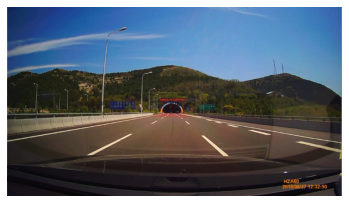

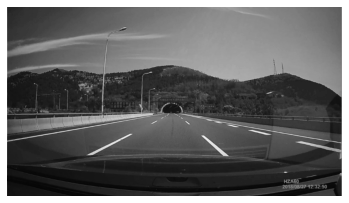

In [5]:
# Manual version takes a long time
# Read image from JPEG file
# Convert to grayscale
pil_im = Image.open("lane_sample1.jpeg")
orig = np.array(pil_im)
# plt.imshow(orig)
# plt.show()

# Resize so that standard height is 512
width = int(pil_im.width * 512 / pil_im.height)
pil_im = pil_im.resize((width , 512))

# Convert to np array
orig_img = np.array(pil_im)
plt.imshow(orig_img)
plt.axis('off')
plt.show()

#Convert to grayscale
im = rgb2gray(orig_img)

# # Deletes the 1 and 2 indices from the rgb parameter so the array can be squeezed
# im = np.delete(im, [1, 2], 2)

plt.imshow(im, cmap='gray')
plt.axis('off')
plt.show()

In [6]:
# Rohit's Otsu's Implementation
def otsu_thresh(input_im):          
    # Set total number of bins in the histogram
    bins_num = int(np.amax(input_im)) + 1
    print(f'Number of bins = {bins_num}')

    # Get the image histogram
    hist, bin_edges = np.histogram(input_im, bins=bins_num, range=(0, bins_num))

    # normalize histogram
    hist = np.divide(hist.ravel(), hist.max())

    # Calculate centers of bins
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.

    # Iterate over all thresholds (indices) and get the probabilities w1(t), w2(t)
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]

    # Get the class means mu0(t)
    mean1 = np.cumsum(hist * bin_mids) / weight1
    # Get the class means mu1(t)
    mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]

    inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

    # Maximize the inter_class_variance function val
    index_of_max_val = np.argmax(inter_class_variance)

    threshold = bin_mids[:-1][index_of_max_val]
    
    print(f'Threshold = {threshold}')         

    return threshold

(5, 5)
(516, 912)
(512, 908)


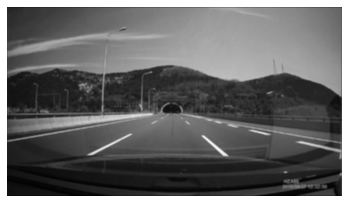

In [7]:
# Tharm's image smoothing
#Implementing image smoothing
rows = im.shape[0]
cols = im.shape[1]

#input any kernel size
kernel_shape_row = 5
kernel_shape_col = 5

kernel = np.ones((kernel_shape_row, kernel_shape_col))/(kernel_shape_row * kernel_shape_col)
mag_smooth = np.zeros((rows,cols))
print(kernel.shape)

#pad with zeros on the border for full blurring of image
padded_gray = np.zeros((rows + kernel_shape_row - 1, cols + kernel_shape_col - 1))
index_1_row = (int) ((kernel_shape_row - 1)/2)
index_last_row = (int) (rows + ((kernel_shape_row - 1)/2))
index_1_col = (int) ((kernel_shape_col - 1)/2)
index_last_col = (int) (cols + ((kernel_shape_col - 1)/2))
padded_gray[index_1_row:index_last_row, index_1_col:index_last_col] = im
print(padded_gray.shape)

for x in range(rows):
    for y in range(cols):
        mag_smooth[x][y] = (kernel * padded_gray[x:x+kernel_shape_row, y:y+kernel_shape_col]).sum()     
        
print(mag_smooth.shape)
plt.imshow(mag_smooth, cmap='gray')
plt.axis('off')
plt.show()

(512, 908)
finished making new image
(512, 908)


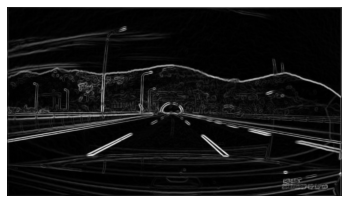

In [8]:
# Tharm's Sobel Edge Detector
## Implementing sobel edge detector
Gx = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
Gy = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]

mag_G = np.zeros((rows,cols))
#mag_G_thresh = np.zeros((rows,cols))
print(mag_G.shape)

for i in range(1, rows - 1):
    for j in range(1, cols - 1):
        sumx = (Gx * mag_smooth[i-1:i+2, j-1:j+2]).sum()
        sumy = (Gy * mag_smooth[i-1:i+2, j-1:j+2]).sum()
        mag_G[i][j] = np.sqrt(sumx**2 + sumy**2)
        
print('finished making new image')
print(mag_G.shape)
plt.imshow(mag_G, cmap='gray')
plt.axis('off')
plt.show()

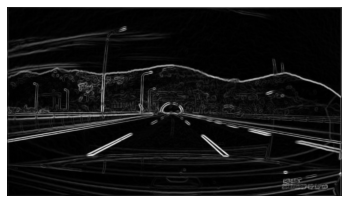

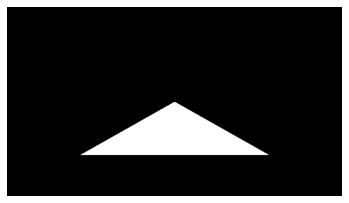

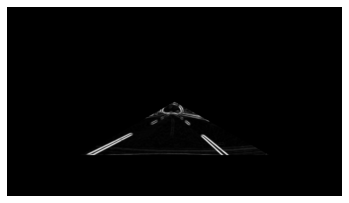

In [9]:
# Own implementation of cropped image
plt.imshow(mag_G, cmap='gray')
plt.axis('off')
plt.show()
mask = np.zeros_like(mag_G)
mask = fillMask(mask)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()
cropped_im = apply_mask(mag_G, mask)
plt.imshow(cropped_im, cmap='gray')
plt.axis('off')
plt.show()

Number of bins = 301
Threshold = 96.5


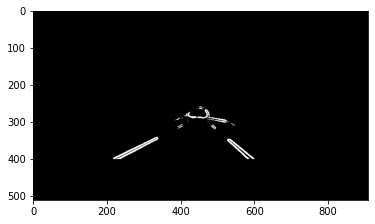

In [10]:
cropped_part = []
for x, row in enumerate(mask):
        for y, col in enumerate(row):
            if mask[x][y] == 255:
                cropped_part.append(cropped_im[x][y])
cropped_part = np.array(cropped_part)
threshold = otsu_thresh(cropped_part)
thresh_im = np.zeros_like(cropped_im)
for x, row in enumerate(cropped_im):
    for y, col in enumerate(row):
        if cropped_im[x][y] >= threshold:
            thresh_im[x][y] = 255
        else:
            thresh_im[x][y] = 0
            
plt.imshow(thresh_im, cmap="gray")
plt.show()

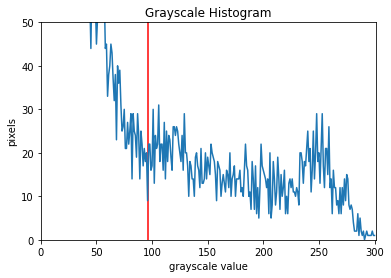

In [11]:
##Making histogram of threshold

maxValue = int(np.amax(cropped_im)) + 1

histogram, bin_edges = np.histogram(cropped_im, bins=maxValue, range=(0,maxValue))
# configure and draw the histogram figure
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim([0, maxValue])
plt.ylim([0, 50]) # must be changed manually after generating once for better visual analysis
plt.vlines(threshold, 0, 200, colors = 'r')

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

In [12]:
# Rohit's code
def Hough_lines(img, line_length):

    height, width = img.shape[:2]
    
    # Creates the accumulator space
    accumulator = np.zeros([180, int(math.sqrt(height ** 2 + width ** 2))])

    lines = np.array([[0, 0], [0, 0]])

    #line_length = 40

    # look for every pixel
    for y in range(0, height):
        for x in range(0, width):
            # if pixel is white (possible part of a line)
            if img[y][x] > 250:
                # try all angles
                # Step = 3 to decrease number of lines
                for theta in range(0, 180, 1):
                    p = int(x * math.cos(math.radians(theta)) + y * math.sin(math.radians(theta)))
                    accumulator[theta][p] += 1
                    # Check if it looks like line and if it's not in a list
                    if (accumulator[theta][p] > line_length) and (p not in lines[:, 0]) and (theta not in  lines[:, 1]):
                        # lines is an array of [rho, theta] pairs that has a lot of points in the accumulator space
                        lines = np.vstack((lines, np.array([p, theta])))

    # clean two first zeros
    lines = np.delete(lines, [0, 1], axis=0)
    
#     print(lines)

    return accumulator, lines

In [13]:
hough_space, point_stack = Hough_lines(thresh_im, 50)

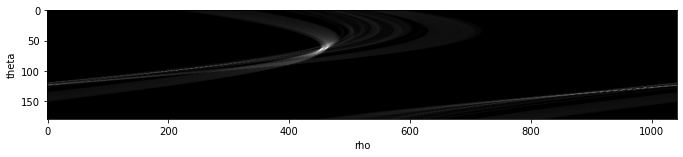

In [14]:
plt.figure(figsize = (20,2))
plt.imshow(hough_space, cmap='gray')
plt.xlabel('rho')
plt.ylabel('theta')
plt.show()

In [15]:
# Outputs gradient and y intersect of the line for y = mx + b
def hough_intersect (rho, theta, image):
    h, w = image.shape[:2]
    out = []
    theta = math.radians(theta)
    intersect = [int(round(rho / math.sin(theta))), int(round((rho - w * math.cos(theta)) / math.sin(theta))), int(round(rho / math.cos(theta))),
                 int(round((rho - h * math.sin(theta)) / math.cos(theta)))]
    
    
    # Use formula to get 2 points in a line, one being 100 pixels from left and another being 100 pixels from right
    x1 = 100
    y1 = int(x1 * (-math.cos(theta)/math.sin(theta)) + rho / math.sin(theta))
    
    x2 = 800
    y2 = int(x2 * (-math.cos(theta)/math.sin(theta)) + rho / math.sin(theta))

    # Gradient
    m = -math.cos(theta)/math.sin(theta)
    # Intersect
    b = rho / math.sin(theta)
    
    out.append(m)
    out.append(b)
    
    return out

In [16]:
# test if hough_intersect works
test = hough_intersect(443, 69, orig)

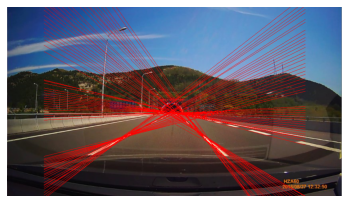

In [17]:
points_coord = [] #To store the coordinates of the lines
orig_line = orig_img.copy()
h, w = orig_img.shape[:2]

gradients = []
line_info = []

for i in point_stack:
    coeff = hough_intersect(i[0], i[1], orig)
    if (len(coeff) > 1):
        m = coeff[0]
        b = coeff[1]
        y1 = m * 100 + b
        y2 = m * (w - 100) + b
        
        gradients.append(m)
        line_info.append((m, b))
        cv.line(orig_line, (100, int(y1)), (w - 100, int(y2)), (255,0,0))

fig = plt.imshow(orig_line)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show()

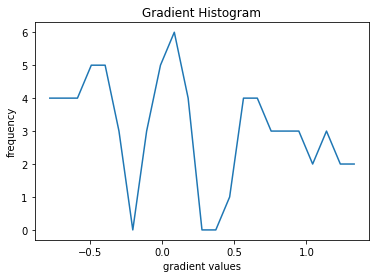

In [18]:
histogram, bin_edges = np.histogram(gradients, bins=int(len(gradients)/3))

# configure and draw the histogram figure
plt.figure()
plt.title("Gradient Histogram")
plt.xlabel("gradient values")
plt.ylabel("frequency")

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

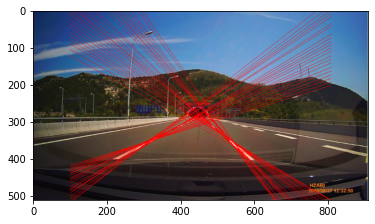

In [19]:
# Exclude lines not from lanes
neg_lines = [line for line in line_info if line[0] < -0.3]
pos_lines = [line for line in line_info if line[0] > 0.3]

cleaned_lines_img = orig_img.copy()

for coeff in pos_lines:
    m = coeff[0]
    b = coeff[1]
    y1 = m * 100 + b
    y2 = m * (w - 100) + b
    cv.line(cleaned_lines_img, (100, int(y1)), (w - 100, int(y2)), (255,0,0))
    
for coeff in neg_lines:
    m = coeff[0]
    b = coeff[1]
    y1 = m * 100 + b
    y2 = m * (w - 100) + b
    cv.line(cleaned_lines_img, (100, int(y1)), (w - 100, int(y2)), (255,0,0))

fig = plt.imshow(cleaned_lines_img)
plt.show()

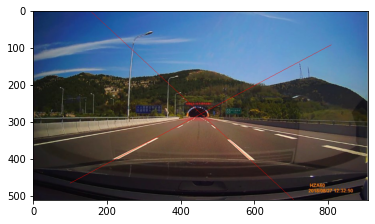

In [20]:
# Compute Average Lines
averaged_lines_img = orig_img.copy()

total_m = 0
total_b = 0
for coeff in pos_lines:
    total_m += coeff[0]
    total_b += coeff[1]
    
pos_m = total_m / len(pos_lines)
pos_b = total_b / len(pos_lines)

total_m = 0
total_b = 0
for coeff in neg_lines:
    total_m += coeff[0]
    total_b += coeff[1]
    
neg_m = total_m / len(neg_lines)
neg_b = total_b / len(neg_lines)

y1 = pos_m * 100 + pos_b
y2 = pos_m * (w - 100) + pos_b
cv.line(averaged_lines_img, (100, int(y1)), (w - 100, int(y2)), (255,0,0))

y1 = neg_m * 100 + neg_b
y2 = neg_m * (w - 100) + neg_b
cv.line(averaged_lines_img, (100, int(y1)), (w - 100, int(y2)), (255,0,0))

fig = plt.imshow(averaged_lines_img)
plt.show()

In [21]:
# Compute Vanishing Point
A = np.array([[-neg_m, 1], [-pos_m, 1]])
B = np.array([neg_b, pos_b])
C = np.linalg.solve(A, B)=

vanished_img = orig_img.copy()


y1 = pos_m * (w - 100) + pos_b
cv.line(vanished_img, (int(C[0]), int(C[1])), (w - 100, int(y1)), (255,0,0))

y2 = neg_m * 100 + neg_b
cv.line(vanished_img, (100, int(y2)), (int(C[0]), int(C[1])), (255,0,0))

fig = plt.imshow(vanished_img)
plt.show()

SyntaxError: invalid syntax (<ipython-input-21-87ab5cb5b5b5>, line 4)

# Color Detection

In [ ]:
# Mask is a zero matrix
# fillMask fills an empty numpy array with 255 for pixels that fits inside the defined triangle
def fillMaskColor(mask, h, w):
    bottom_left = (h, 0)
    middle = (int(h/2), int(w/2))
    bottom_right = (h, w)
    
    for x, row in enumerate(mask):
        for y, col in enumerate(row):
            # Applying equations to left_bound and right_bound
            left_bound = (h - x) * middle[1] / middle[0]
            right_bound = x * middle[1] / middle[0]
            if y > left_bound and y < right_bound and x <= 400:
                mask[x][y][0] = 255 #red
                mask[x][y][1] = 255 #green
                mask[x][y][2] = 255 #blue
                
    return mask

In [ ]:
# For each non-zero pixel in mask, the corresponding pixel on image is kept (the rest of the pixels in mask is discarded)
def apply_mask_color(image, mask):
    for x, row in enumerate(mask):
        for y, col in enumerate(row):
            if mask[x][y][0] != 255:
                image[x][y][0] = 0
                image[x][y][1] = 0
                image[x][y][2] = 0
    return image

In [ ]:
#add original image back
orig_img = np.array(pil_im)
plt.imshow(orig_img)
plt.title('Resized color image')
plt.axis('off')
plt.show()

rows = orig_img.shape[0]
cols = orig_img.shape[1]
colorMask = np.zeros((rows, cols, 3))
colorMask = fillMaskColor(colorMask, rows, cols)
plt.imshow(colorMask)
plt.title('Color mask')
plt.axis('off')
plt.show

croppedImageColor = apply_mask(orig_img, mask)
plt.imshow(croppedImageColor)
plt.title('Color mask applied')
plt.axis('off')
plt.show()

## RBG to HSV

In [ ]:
def RGB_to_HSV(rgb):
    
    rows = rgb.shape[0]
    cols = rgb.shape[1]
    hsvImage = np.zeros((rows, cols, 3))
    
    for y in range(rows):
        for x in range(cols):
            redPrime = rgb[y,x,0] / 255
            greenPrime = rgb[y,x,1] / 255
            bluePrime = rgb[y,x,2] / 255
            cMax = max(redPrime, greenPrime, bluePrime)
            cMin = min(redPrime, greenPrime, bluePrime)
            delta = cMax - cMin
            
            #hue (color wheel (0 <= hue < 360))
            if delta == 0: #if there is no net hue (no dominating color) of a pixel, set the hue to 0
                hsvImage[y][x][0] = 0
            elif cMax == redPrime:
                hsvImage[y][x][0] = (60 * ((greenPrime - bluePrime) / delta) + 360) % 360 #reds are the first third of the color wheel
            elif cMax == greenPrime:
                hsvImage[y][x][0] = (60 * ((bluePrime - redPrime) / delta) + 120) % 360 #greens are the second third of the color wheel
            elif cMax == bluePrime:
                hsvImage[y][x][0] = (60 * ((redPrime - greenPrime) / delta) + 240) % 360 #blues are the third third of the color wheel
            
            #saturation (lower value is more white, higher value is more colored (0 <= saturation <= 1000))
            if cMax == 0: #black
                hsvImage[y][x][1] = 0
            else:
                hsvImage[y][x][1] = (delta / cMax) * 1000 #in permille
            
            #value (lower value is more black, higher value is more colored (0 <= saturation <= 1000))
            hsvImage[y][x][2] = cMax * 1000 #in permille
    
    return hsvImage

In [ ]:
imHSV = RGB_to_HSV(croppedImageColor) #convert the RGB array to an HSV array

#extract hue, saturation, and value
hueImg = imHSV[:,:,0]
satImg = imHSV[:,:,1]
valImg = imHSV[:,:,2]

plt.imshow(croppedImageColor)
plt.title("RGB image (original resized with mask)")
plt.axis('off')
plt.show()

plt.imshow(hueImg, cmap = 'hsv')
plt.title("Hue channel")
plt.axis('off')
plt.show()

plt.imshow(satImg)
plt.title("Saturation channel")
plt.axis('off')
plt.show()

plt.imshow(valImg)
plt.title("Value channel")
plt.axis('off')
plt.show()

## Histogram hue, saturation, and value

In [ ]:
#use only the cropped section
croppedHue = []
for x, row in enumerate(colorMask):
        for y, col in enumerate(row):
            if colorMask[x][y][0] == 255:
                croppedHue.append(hueImg[x][y])
croppedHue = np.array(croppedHue)

maxHueValue = int(np.amax(croppedHue)) + 1

hueHistogram, hueBinEdges = np.histogram(croppedHue, bins=maxHueValue, range=(0,maxHueValue))
# configure and draw the histogram figure
plt.figure()
plt.title("Hue Histogram")
plt.xlabel("Hue (degrees)")
plt.ylabel("pixels")
plt.xlim([0, maxHueValue])
plt.ylim([0, 5000]) # must be changed manually after generating once for better visual analysis

plt.plot(hueBinEdges[0:-1], hueHistogram)  # <- or here
plt.show()

#use only the cropped section
croppedSat = []
for x, row in enumerate(colorMask):
        for y, col in enumerate(row):
            if colorMask[x][y][0] == 255:
                croppedSat.append(satImg[x][y])
croppedSat = np.array(croppedSat)

maxSatValue = int(np.amax(croppedSat)) + 1

satHistogram, satBinEdges = np.histogram(croppedSat, bins=maxSatValue, range=(0,maxSatValue))
# configure and draw the histogram figure
plt.figure()
plt.title("Saturation Histogram")
plt.xlabel("Saturation (permille)")
plt.ylabel("pixels")
plt.xlim([0, maxSatValue])
plt.ylim([0, 750]) # must be changed manually after generating once for better visual analysis

plt.plot(satBinEdges[0:-1], satHistogram)  # <- or here
plt.show()

#use only the cropped section
croppedVal = []
for x, row in enumerate(colorMask):
        for y, col in enumerate(row):
            if colorMask[x][y][0] == 255:
                croppedVal.append(valImg[x][y])
croppedVal = np.array(croppedVal)

maxValValue = int(np.amax(croppedVal)) + 1

valHistogram, valBinEdges = np.histogram(croppedVal, bins=maxValValue, range=(0,maxValValue))
# configure and draw the histogram figure
plt.figure()
plt.title("Value Histogram")
plt.xlabel("Value (permille)")
plt.ylabel("pixels")
plt.xlim([0, maxValValue])
plt.ylim([0, 1000]) # must be changed manually after generating once for better visual analysis

plt.plot(valBinEdges[0:-1], valHistogram)  # <- or here
plt.show()

## Detection

In [ ]:
def getColor(hue, saturation, value):
    if saturation <= 200:
        return "white"
    elif hue <= 300: #most pixels have a very low hue, so this must be fixed since it's counting the pavement
        return "red"
    elif hue <= 800:
        return "yellow"

In [ ]:
#currently can only detect yellow and white since it treats the unmarked pavement as red which will be fixed later, needs to be tested with multiple images

#number of pixels with that color
yellows = 0
whites = 0
reds = 0

for y in range(rows):
    for x in range(cols):
        if (colorMask[y][x][0] != 0): #unmasked region
            yLine1 = int(m1 * x + c1) #find lane line y value corresponding to the x value for the left lane line
            yLine2 = int(m2 * x + c1) #find lane line y value corresponding to the x value for the right lane line
            if ((y == yLine1) or (y == yLine2)): #pixel on line
                pixelColor = getColor(hueImg[y][x], satImg[y][x], valImg[y][x]) #get the color (string) of that pixel
                if pixelColor == "yellow":
                    yellows += 1
                elif pixelColor == "white":
                    whites += 1
                #elif pixelColor == "red":
                    #reds += 1

#decide the most dominant color
if yellows == max(yellows, whites, reds):
    laneColor = "yellow"
elif reds == max(yellows, whites, reds):
    laneColor = "red"
elif whites == max(yellows, whites, reds):
    laneColor = "white"


#xTest = 330
#yTest = int(m1 * xTest + c1)
#print(f'{croppedImageColor[yTest][xTest][0]} {croppedImageColor[yTest][xTest][1]} {croppedImageColor[yTest][xTest][2]}')
print(f'There are {yellows} yellow pixels on the lane lines in the mask.')
print(f'There are {whites} white pixels on the lane lines in the mask.')
#print(f'There are {reds} red pixels on the lane lines in the mask.')
print(f'The color of the lane markings is {laneColor}.')

#plt.imshow(croppedImageColor)
#plt.axis('on')
#plt.show